# Introduction

Dans ce notebook, nous allons essayer de mettre en place des modèles de réseaux de neurones récurrents sur les données NO2 issus de capteurs de la sud 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_PATH = "../../data/clean/sud3_no2.pkl"
PATIENCE = 5

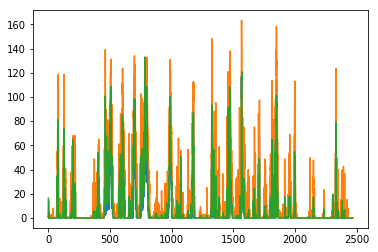

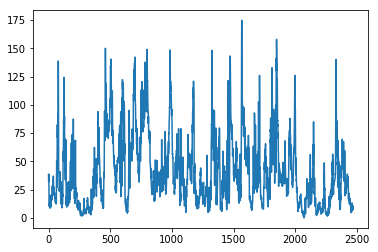

,index,date,ref,NO2_61FD,NO2_61F0,NO2_61EF,rh,t_grad,pressure,temp,pluvio
2458,2458,2017-10-24 00:45:00,5.5,0.0,0.0,0.0,88.3,-0.8,1020.4,15.5,0.0
2459,2459,2017-10-24 01:00:00,8.6,0.0,0.0,0.0,88.7,-0.9,1020.4,15.5,0.0
2460,2460,2017-10-24 01:15:00,13.2,0.0,0.0,0.0,88.7,-0.9,1020.4,15.5,0.0
2461,2461,2017-10-24 01:30:00,9.5,0.0,0.0,0.0,89.0,-0.9,1020.4,15.5,0.0
2462,2462,2017-10-24 01:45:00,10.5,0.0,0.0,0.0,89.0,-0.9,1020.4,15.5,0.0
2463,2463,2017-10-24 02:00:00,8.7,0.0,0.0,0.0,89.2,-0.9,1020.2,15.6,0.0
2464,2464,2017-10-24 02:15:00,10.3,0.0,0.0,0.0,89.3,-0.9,1020.2,15.6,0.0
2465,2465,2017-10-24 02:30:00,7.7,0.0,0.0,0.0,89.1,-0.9,1020.0,15.6,0.0
2466,2466,2017-10-24 02:45:00,6.9,0.0,0.0,0.0,89.0,-0.9,1020.1,15.7,0.0
2467,2467,2017-10-24 03:00:00,10.7,0.0,0.0,0.0,89.0,-0.9,1020.3,15.7,0.0


In [3]:
df = pd.read_pickle(DATA_PATH)
df = df.reset_index()
df = df.dropna()

plt.plot(df["NO2_61FD"])
plt.plot(df["NO2_61F0"])
plt.plot(df["NO2_61EF"])

plt.show()

plt.plot(df["ref"])
plt.show()
df.tail(10)

# Pré-traitement

On définit dans un premier des méthodes afin de transformer notre jeu de données en séquences.

In [4]:
def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 't_grad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y.append(np.array(df.iloc[i]['ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train, 16)
X_valid, y_valid = dataframe_to_xy(df_valid, 16)
X_test, y_test = dataframe_to_xy(df_test, 16)

# Modèles

Nous allons tester 3 modèles récurrents: un modèle récurrent simple (SimpleRNN), un modèle LSTM et un modèle GRU

In [5]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=PATIENCE)

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(SimpleRNN(nb_units, activation='tanh', input_shape=input_dim, return_sequences=True))
    model.add(SimpleRNN(nb_units, activation='tanh'))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(LSTM(nb_units, activation='tanh', input_shape=input_dim, return_sequences=True))
    model.add(LSTM(nb_units, activation='tanh'))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer=Adam(lr=3e-4)):
    model = Sequential()
    model.add(GRU(nb_units, activation='tanh', input_shape=input_dim, return_sequences=True))
    model.add(GRU(nb_units, activation='tanh'))
    model.add(Dense(nb_units//2, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

Using TensorFlow backend.


## Simple RNN

### Apprentissage

In [6]:
model = simple_rnn_model(16, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=1, epochs=1000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 16, 16)            400       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________
Train on 1191 samples, validate on 587 samples
Epoch 1/1000
1191/1191 [==============================] - 6s 5ms/step - loss: 1871.3641 - val_loss: 1716.5232
Epoch 2/1000
1191/1191 [==============================] - 6s 5ms/step - loss: 1056.8796 - val_loss: 1130.5772
Epoch

### Courbes de résultats pour modèle RNN

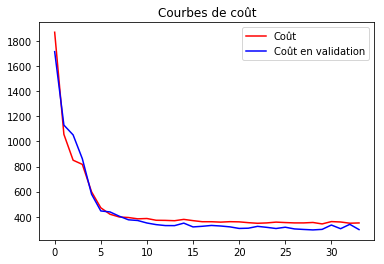

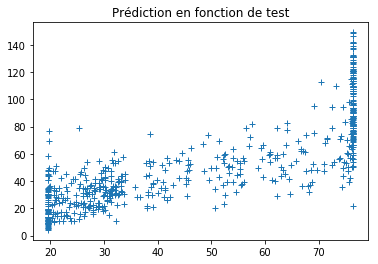

In [7]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## LSTM

### Apprentissage

In [8]:
model = lstm_model(16, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=1, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping,], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16, 16)            1600      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________
Train on 1191 samples, validate on 587 samples
Epoch 1/5000
1191/1191 [==============================] - 20s 16ms/step - loss: 1959.3819 - val_loss: 2018.2325
Epoch 2/5000
1191/1191 [==============================] - 19s 16ms/step - loss: 1363.5314 - val_loss: 1432.5433
E

### Courbes de résultats pour modèle LSTM

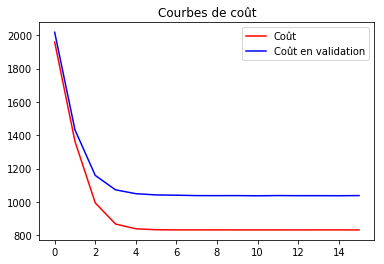

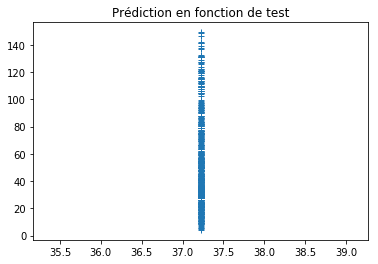

In [9]:
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], 'r-', label="Coût")
plt.plot(history.history['val_loss'], 'b-', label="Coût en validation")
plt.title("Courbes de coût")
plt.legend()
plt.show()

plt.title('y_pred, y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.title("Prédiction en fonction de test")
plt.show()

## GRU

### Apprentissage

In [10]:
model = gru_model(16, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=1, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16, 16)            1200      
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                1584      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 2,929
Trainable params: 2,929
Non-trainable params: 0
_________________________________________________________________
Train on 1191 samples, validate on 587 samples
Epoch 1/5000
1191/1191 [==============================] - 17s 14ms/step - loss: 1774.6104 - val_loss: 1562.6357
Epoch 2/5000
1191/1191 [==============================] - 16s 14ms/step - loss: 974.9764 - val_loss: 1085.9258
Ep

### Courbes de résultats pour modèle GRU

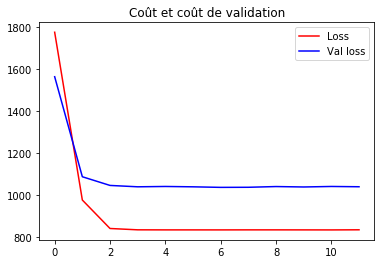

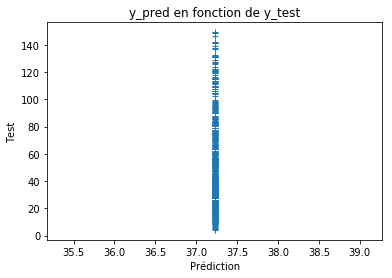

In [11]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

# Conclusion

Nous avons testé des modèles récurrents avec des séquences de points. Malheureusement les modèles LSTM et GRU n'arrivent pas à passer le palier de 1000 de loss à la différence du simple modèle récurrent. Plusieurs paramètres ont été testés sur ces modèles afin d'essayer de passer ce palier:
  * Un **look_back** plus grand et plus petit
  * Des modèles récurrents avec une seule couche récurrente et également 3 couches récurrentes
  * Des batchs sizes variant de 1 à 32
  * L'utilisation comme optimizer d'un SGD avec des petits pas d'apprentissage (10e-6)
Ces résultats peuvent s'expliquer par la majorité de valeurs à 0 pour les micro capteurs à la différence de la valeur de référence.